In [29]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree

# Data Overview and Preprocessing
This dataset has been taken from kaggle (https://www.kaggle.com/datasets/imnikhilanand/heart-attack-prediction/data)

In [30]:
# Download dataset from kaggle
path = kagglehub.dataset_download("imnikhilanand/heart-attack-prediction")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\David\.cache\kagglehub\datasets\imnikhilanand\heart-attack-prediction\versions\1


In [31]:
# Load and preview data
data = pd.read_csv(path+"/data.csv")
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,28,1,2,130,132,0,2,185,0,0.0,?,?,?,0
1,29,1,2,120,243,0,0,160,0,0.0,?,?,?,0
2,29,1,2,140,?,0,0,170,0,0.0,?,?,?,0
3,30,0,1,170,237,0,1,170,0,0.0,?,?,6,0
4,31,0,2,100,219,0,1,150,0,0.0,?,?,?,0


The data overview shows that columns that are meant to be numeric are including string values like "?" which is not further defined in the documentation. Therefore we will treat this value as a missing value and replace it with None. Afterwards, the datatypes of the corrected columns must be converted to numeric in order to enable further analysis.

In [32]:
# Handling missing values by replacing ? with None values
data_cleared = data.replace("?", None)
data_cleared.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,28,1,2,130,132,0,2,185,0,0.0,None,None,None,0
1,29,1,2,120,243,0,0,160,0,0.0,None,None,None,0
2,29,1,2,140,None,0,0,170,0,0.0,None,None,None,0
3,30,0,1,170,237,0,1,170,0,0.0,None,None,6,0
4,31,0,2,100,219,0,1,150,0,0.0,None,None,None,0


In [33]:
# Convert column datatypes to numeric
data_cleared["trestbps"] = pd.to_numeric(data_cleared["trestbps"])
data_cleared["chol"] = pd.to_numeric(data_cleared["chol"])
data_cleared["fbs"] = pd.to_numeric(data_cleared["fbs"])
data_cleared["restecg"] = pd.to_numeric(data_cleared["restecg"])
data_cleared["thalach"] = pd.to_numeric(data_cleared["thalach"])
data_cleared["exang"] = pd.to_numeric(data_cleared["exang"])
data_cleared["slope"] = pd.to_numeric(data_cleared["slope"])
data_cleared["ca"] = pd.to_numeric(data_cleared["ca"])
data_cleared["thal"] = pd.to_numeric(data_cleared["thal"])
data_cleared.dtypes

age             int64
sex             int64
cp              int64
trestbps      float64
chol          float64
fbs           float64
restecg       float64
thalach       float64
exang         float64
oldpeak       float64
slope         float64
ca            float64
thal          float64
num             int64
dtype: object

Now that we have replaced the "?" values with None values and converted the datatypes to numeric, we can have a look at some descriptive measures.

In [34]:
data = data_cleared
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,294.000000,294.000000,294.000000,293.000000,271.000000,286.000000,293.000000,293.000000,293.000000,294.000000,104.000000,3.0,28.000000,294.000000
mean,47.826531,0.724490,2.982993,132.583618,250.848708,0.069930,0.218430,139.129693,0.303754,0.586054,1.894231,0.0,5.642857,0.360544
std,7.811812,0.447533,0.965117,17.626568,67.657711,0.255476,0.460868,23.589749,0.460665,0.908648,0.338995,0.0,1.615074,0.480977
min,28.000000,0.000000,1.000000,92.000000,85.000000,0.000000,0.000000,82.000000,0.000000,0.000000,1.000000,0.0,3.000000,0.000000
25%,42.000000,0.000000,2.000000,120.000000,209.000000,0.000000,0.000000,122.000000,0.000000,0.000000,2.000000,0.0,5.250000,0.000000
50%,49.000000,1.000000,3.000000,130.000000,243.000000,0.000000,0.000000,140.000000,0.000000,0.000000,2.000000,0.0,6.000000,0.000000
75%,54.000000,1.000000,4.000000,140.000000,282.500000,0.000000,0.000000,155.000000,1.000000,1.000000,2.000000,0.0,7.000000,1.000000
max,66.000000,1.000000,4.000000,200.000000,603.000000,1.000000,2.000000,190.000000,1.000000,5.000000,3.000000,0.0,7.000000,1.000000


Thanks to our preprocessing, the columns are now treated as numeric and can be analysed accordingly. 

The "count" row gives us an understanding of how often the value is present and how often it is missing. Among the 294 rows, the "ca" column for example only has 3 values that are not None.

The "mean" and "std" columns tell us the mean and standard deviation of each column.
The "min" and "max" values give us minimum and maximum values of each column.

# Heart Attack Prediction
Lets start try out different classifiers on this dataset and attempt to optimize them using GridsearchCV.

## GridSearch-optimised DecisionTreeClassifier

In [35]:
# Define X and y data and partition them into training and test data
X = data.iloc[:, 0:13]
y = data.iloc[:, 13]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=77)

clf = tree.DecisionTreeClassifier(random_state=101)

param_grid = [{
  'max_depth': [2, 3, 4, 5, 6], 
  'ccp_alpha' : [0, 0.05, 0.1, 0.15, 0.2], 
  'max_features' : [None, 3, 4, 5, 6, 7, 8]
}]

gs = GridSearchCV(clf, param_grid)
gs = gs.fit(X_train, y_train)

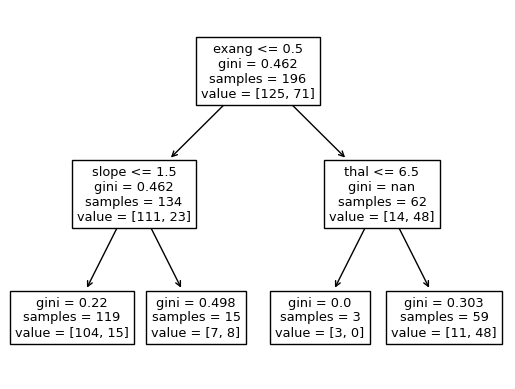

In [36]:
# Visualise the decision tree
ann = tree.plot_tree(gs.best_estimator_, feature_names=data.columns)
plt.savefig('out.pdf')

In [37]:
# Print the parameters selected by the GridSearch
print("Selected parameters of the best estimator:")
print("max_depth="+str(gs.best_estimator_.max_depth))
print("max_features="+str(gs.best_estimator_.max_features_))
print("ccp_alpha="+str(gs.best_estimator_.ccp_alpha))

Selected parameters of the best estimator:
max_depth=2
max_features=6
ccp_alpha=0


In [38]:
# Make prediction on the test data and evaluate the accuracy of the decision tree classifier
y_pred = gs.best_estimator_.predict(X_test)
score = accuracy_score(y_test, y_pred)
print("Score: "+str(score))

Score: 0.8367346938775511


## GridSearch-optimised RandomForestClassifier

In [39]:
# Remove major NAN-columns and afterwards rows with NAN-values in them
# this is necessary for the sklearn RandomForestClassifier to work
pure_data = data.drop(columns=["slope", "ca", "thal"])
pure_data = pure_data.dropna(how="any", axis=0)

In [66]:
# Define X and y data and partition them into training and test data
X = pure_data.iloc[:, 0:10]
y = pure_data.iloc[:, 10]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=77)

clf = RandomForestClassifier(random_state=101)
#clf.fit(X_train, y_train)

param_grid = [{
  'n_estimators': [10, 25, 50, 100, 250],
  'ccp_alpha': [0.0, 0.05, 0.1, 0.15, 0.2],
  'max_depth': [None, 1, 2, 3, 4, 5],
  'max_features': [None, 3, 4, 5, 6, 7, 8]
}]

gs = GridSearchCV(clf, param_grid)
gs = gs.fit(X_train, y_train)

In [68]:
# Print the parameters selected by the GridSearch
print("Selected parameters of the best estimator:")
print("n_estimators="+str(gs.best_estimator_.n_estimators))
print("ccp_alpha="+str(gs.best_estimator_.ccp_alpha))
print("max_features="+str(gs.best_estimator_.max_features))
print("max_depth="+str(gs.best_estimator_.max_depth))

Selected parameters of the best estimator:
n_estimators=250
ccp_alpha=0.0
max_features=4
max_depth=2


In [69]:
# Make prediction on the test data and evaluate the accuracy of the decision tree classifier
y_pred = gs.best_estimator_.predict(X_test)
score = accuracy_score(y_test, y_pred)
print("Score: "+str(score))

Score: 0.8505747126436781


## GridSearch-optimised GradientBoostingClassifier

In [43]:
# Define X and y data and partition them into training and test data
X = data.iloc[:, 0:13]
y = data.iloc[:, 13]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=77)

clf = HistGradientBoostingClassifier(random_state=101)

param_grid = [{
  'learning_rate': [0.05, 0.1, 0.2, 0.5],
  'max_depth': [2, 3, 4, 5, 6]
}]

gs = GridSearchCV(clf, param_grid)
gs = gs.fit(X_train, y_train)

In [44]:
# Print the parameters selected by the GridSearch
print("Selected parameters of the best estimator:")
print("learning_rate="+str(gs.best_estimator_.learning_rate))
print("max_depth="+str(gs.best_estimator_.max_depth))

Selected parameters of the best estimator:
learning_rate=0.2
max_depth=5


In [45]:
# Make prediction on the test data and evaluate the accuracy of the decision tree classifier
y_pred = gs.best_estimator_.predict(X_test)
score = accuracy_score(y_test, y_pred)
print("Score: "+str(score))

Score: 0.8061224489795918


## Conclusion
In this exercise, we worked on a classification exercise. After preprocessing the dataset and handling missing values, the classification problem has been approached using different classifiers, such as DecisionTree, RandomForest and GradientBossting. These classifiers have been hyperparameter-optimised using a Gridsearch-Cross-Validation.

The best performing model is RandomForest with a test accuracy score of 85%.